# How covid-19 narratives are related to its propagation on social media?

**Author**: Muheng Yan

------------------------------------------------------------------------------------------------------------------------------

# Re-organizing RQs

Previously we have discovered the relationship between "actants' homophily"/"actants' LIWC scores" and the color coding/popularity.

Back to the general big RQ: "how stories are told and how it is affecting the cascade?", I re-organize the previous results into these three detailed RQs:


### RQ1: What are the story-tellings of the COVID-19 related articles, in terms of how story subjects are linked, how the subjects are used with specific linguistic cues (i.e. LIWC features), and how the subjects are forming well-known rumors?


### RQ2: How much the story-tellings of the COVID-19 articles are affecting their propagation in social media, in size and velocity?



# Decomposition of RQs

From the two RQs I take three lines of works:

### 1). What is the connectivity pattern for story subjects? How are they related to the propagation features? How are they evolving across weeks?

### 2). How are the subjects used with LIWC features? Relations to propagation? How evolved?

### 3). How the subjects are forming rumors? Relations to propagation? How evolved?


For each line I inspect the corresponding features and their relationship to propagation features. Previously I have shown results of the first two lines of features and their relationship to "propagation size" (audience size normalized popularity). In this node I will extend the results with: 1. weekly sliced results and 2. relationships with "propagation velocity"


# Data Involved

In this notebook I will use the processed articles of the first 6 weeks of our dataset: week 4, 5, 6, 7, 8, 9 of year 2020. The processing (parsing and relation extraction) for the full articles of month March and April is still ongoing. They will be later added when finished.

For each article I used the TITLE and FIRST SENTENCE as the base of investigations. Articles will only be shown partially (usually title and first sentence) in the embedded Tweets so that it would greatly reduce the noise when investigating their relationships with social media propagation features.

# A few Important Features and their Description

***Connectivity probabilities***: ratio of neighbors of a node belongs to the specific color. E.g. 0.1 of "green" in connectivity probability refers 10% of the node's neighbor are green nodes.

***Homophily***: ratio of neighbors of a node belongs to the "SAME" color. E.g. 0.1 of homophily for a red node indicates that 10% of its neighbors are red.

***LIWC features***: proportion of actants in a node appeared with the spicific LIWC features in a same sentence. E.g. node "man" consists of two actants of "man" appeared once with "negate", then the "negate" score for the node is 0.5.

***Popularity***: the average popularity scores ((#rt + #favorate)/(#followers + epsilon) per article) of articles  where any actants in a node appeared in.

***Lifespan***: the average lifespan of articles (last post date - first post date in hours) where any actants in a node appeared in.

***Halflife***: the average "hours an article get 50% shares" where any actants in a node appeared in.

***Velocity Ratio***: the average "halflife / lifespan" of areticles where any actants in a node appeared in.

In [1]:
#utils
import pandas as pd
import pickle

import numpy as np
import networkx as nx

from sklearn import preprocessing

import os

from tqdm import tqdm
from utils import *

import matplotlib.pyplot as plt
import matplotlib

COLORS = ['green', 'yellow', 'orange', 'red', 'black']
non_mix_COLORS = ['green', 'yellow', 'orange', 'red']
WEEKS = range(4, 10)

LIWC_KEYS = ['achieve', 'adverb', 'affect', 'anger', 'anx', 'article', 'assent', 
             'auxverb', 'bio', 'body', 'cause', 'certain', 'cogmech', 'conj', 'death', 
             'dic_wc', 'discrep', 'excl', 'family', 'feel', 'filler', 'friend', 
             'funct', 'future', 'health', 'hear', 'home', 'humans', 'i', 'incl', 
             'ingest', 'inhib', 'insight', 'ipron', 'leisure', 'money', 'motion', 
             'negate', 'negemo', 'nonfl', 'number', 'p1', 'p2', 'p3', 'past', 
             'percept', 'posemo', 'ppron', 'preps', 'present', 'pronoun', 'quant', 
             'relativ', 'relig', 'sad', 'see', 'sexual', 'shehe', 'social', 
             'space', 'swear', 'tentat', 'they', 'time', 'verb', 'wc', 'we', 'work', 'you']

features = [
    'name', 'week', 'color',
    'self_green', 'self_yellow', 'self_orange', 'self_red',
    'connect_green', 'connect_yellow', 'connect_orange', 'connect_red', 'connect_mix',
    'homophily', 'freq', 'degree'
]
features += LIWC_KEYS
features += ['pop', 'rt', 'fav', 'lifespan', 'halflife', 'velocity_ratio']

def lighten_color(color, amount=0.5):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.

    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    """
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])


# Basic stats of per-week graphs
This is the volumns of #articles/nodes per week from last week's results

In [2]:
# img = plt.imread('graph_stats.png')
# plt.figure(figsize=(200, 150))
# fig = plt.imshow(img)
# plt.axis('off')
# plt.show()

In [3]:
#agg dataset of nodes by weeks
weeks = WEEKS
overwrite = False

if not overwrite and os.path.exists('data/cache/nodes_df.pkl'):
    weekly_nodes_df = pickle.load(open('data/cache/nodes_df.pkl', 'rb'))

else:
    weekly_nodes_df = pd.DataFrame(columns=features)

    for week in weeks:
        G, GD, nodes_in_graph, und_edges_in_graph, dir_edges_in_graph = pickle.load(open(f'output/graph_title+1s_week_{week}.pkl', 'rb'))
        node_list = list(G.nodes())


        _baseline_colors = np.zeros(5)
        for nd in node_list:
            color = take_node_color(nodes_in_graph[nd]['norm_color'])
            _baseline_colors[COLORS.index(color)] += 1

        _baseline_colors = _baseline_colors / np.sum(_baseline_colors)

        for nd in tqdm(node_list):

            row = []
            node_name = nd

            nbs = G.neighbors(nd)
            connected = np.zeros(5)

            self_color = take_node_color(nodes_in_graph[nd]['norm_color'])

            for nb in nbs:    
                _nbc = take_node_color(nodes_in_graph[nb]['norm_color'])
                connected[COLORS.index(_nbc)] += 1


            connected = connected / np.sum(connected)
            norm_connected = connected/_baseline_colors            

            norm_connected = norm_connected / np.sum(norm_connected) # vec
            self_color_prob = nodes_in_graph[nd]['color'] # vec
            homophily = norm_connected[COLORS.index(self_color)] #scalar

            LIWCs = nodes_in_graph[nd]['LIWC']

            pop = nodes_in_graph[nd]['pop']
            rt = nodes_in_graph[nd]['rt']
            fav = nodes_in_graph[nd]['fav']
            freq = nodes_in_graph[nd]['freq']

            vel_life = nodes_in_graph[nd]['vel_life']
            vel_mid = nodes_in_graph[nd]['vel_mid']
            vel_ratio = nodes_in_graph[nd]['vel_ratio']


            row = [node_name, week, COLORS.index(self_color)]
            row += list(self_color_prob)
            row += list(norm_connected)
            row.append(homophily)
            row.append(freq)
            row.append(G.degree(nd))
            row += list(LIWCs)
            row += [pop, rt, fav, vel_life, vel_mid, vel_ratio]


            row = pd.Series(row, index = all_nodes_df.columns)
            weekly_nodes_df = weekly_nodes_df.append(row, ignore_index=True)
            
    
    pickle.dump(weekly_nodes_df, open('data/cache/nodes_df.pkl', 'wb'))

In [4]:
#dataset of nodes across weeks

overwrite = False
if not overwrite and os.path.exists('data/cache/nodes_df_unified.pkl'):
    all_nodes_df = pickle.load(open('data/cache/nodes_df_unified.pkl', 'rb'))

else:
    all_nodes_df = pd.DataFrame(columns=features)

    G, GD, nodes_in_graph, und_edges_in_graph, dir_edges_in_graph = pickle.load(open(f'output/graph_title+1s_all.pkl', 'rb'))
    node_list = list(G.nodes())
    

    _baseline_colors = np.zeros(5)
    for nd in node_list:
        color = take_node_color(nodes_in_graph[nd]['norm_color'])
        _baseline_colors[COLORS.index(color)] += 1

    _baseline_colors = _baseline_colors / np.sum(_baseline_colors)

    for nd in tqdm(node_list):

        row = []
        node_name = nd

        nbs = G.neighbors(nd)
        connected = np.zeros(5)

        self_color = take_node_color(nodes_in_graph[nd]['norm_color'])

        for nb in nbs:    
            _nbc = take_node_color(nodes_in_graph[nb]['norm_color'])
            connected[COLORS.index(_nbc)] += 1


        connected = connected / np.sum(connected)
        norm_connected = connected/_baseline_colors            

        norm_connected = norm_connected / np.sum(norm_connected) # vec
        self_color_prob = nodes_in_graph[nd]['color'] # vec
        homophily = norm_connected[COLORS.index(self_color)] #scalar

        LIWCs = nodes_in_graph[nd]['LIWC']

        pop = nodes_in_graph[nd]['pop']
        rt = nodes_in_graph[nd]['rt']
        fav = nodes_in_graph[nd]['fav']
        freq = nodes_in_graph[nd]['freq']

        vel_life = nodes_in_graph[nd]['vel_life']
        vel_mid = nodes_in_graph[nd]['vel_mid']
        vel_ratio = nodes_in_graph[nd]['vel_ratio']


        row = [node_name, 'NA', COLORS.index(self_color)]
        row += list(self_color_prob)
        row += list(norm_connected)
        row.append(homophily)
        row.append(freq)
        row.append(G.degree(nd))
        row += list(LIWCs)
        row += [pop, rt, fav, vel_life, vel_mid, vel_ratio]


        row = pd.Series(row, index = all_nodes_df.columns)
        all_nodes_df = all_nodes_df.append(row, ignore_index=True)
            
    
    pickle.dump(all_nodes_df, open('data/cache/nodes_df_unified.pkl', 'wb'))

In [5]:
weekly_nodes_df.head()

,name,week,color,self_green,self_yellow,self_orange,self_red,connect_green,connect_yellow,connect_orange,...,wc,we,work,you,pop,rt,fav,lifespan,halflife,velocity_ratio
0,SUPER:man|woman,4,4,0.185185,0.592593,0.000000,0.222222,0.056702,0.050480,0.000000,...,1.0,0.000000,0.065217,0.000000,0.003194,2.370370,2.592593,49.366389,8.767500,0.164886
1,dud,4,3,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,1.0,0.000000,0.000000,0.000000,0.015267,2.000000,2.000000,1626.524167,169.941944,0.104482
2,SUPER:centre|hub,4,1,0.166667,0.833333,0.000000,0.000000,0.089860,0.059999,0.000000,...,1.0,0.166667,0.500000,0.000000,0.001826,2.166667,3.000000,46.273472,5.196250,0.169575
3,heathrow,4,1,0.000000,1.000000,0.000000,0.000000,0.000000,0.197531,0.000000,...,1.0,0.000000,1.000000,0.000000,0.003086,2.000000,3.500000,4.312222,0.051111,0.505926
4,SUPER:chinese_government|uk_government|government,4,1,0.000000,0.833333,0.055556,0.111111,0.131224,0.262852,0.167504,...,1.0,0.111111,1.000000,0.037037,0.003411,6.833333,7.055556,49.125833,3.373333,0.095666


In [6]:
all_nodes_df.head()

,name,week,color,self_green,self_yellow,self_orange,self_red,connect_green,connect_yellow,connect_orange,...,wc,we,work,you,pop,rt,fav,lifespan,halflife,velocity_ratio
0,SUPER:man|woman,NA,4,0.236301,0.578767,0.102740,0.082192,0.088333,0.131471,0.086881,...,1.0,0.038043,0.369565,0.023551,0.013907,3.143836,5.441781,12.506667,1.380278,0.491665
1,SUPER:matt_hancock|dud,NA,3,0.333333,0.333333,0.000000,0.333333,0.000000,0.000000,0.000000,...,1.0,0.000000,0.250000,0.000000,0.001421,6.333333,5.666667,0.000000,0.000000,1.000000
2,SUPER:oak_medical_centre|centre|hub,NA,4,0.162162,0.540541,0.189189,0.108108,0.029900,0.089005,0.196060,...,1.0,0.045455,0.500000,0.022727,0.007711,2.216216,3.243243,12.130278,3.146389,0.554232
3,heathrow,NA,1,0.000000,0.800000,0.000000,0.200000,0.000000,0.000000,0.000000,...,1.0,0.000000,0.666667,0.000000,0.000671,0.200000,0.200000,7.220556,1.487778,0.206048
4,SUPER:chinese_government|uk_government|government,NA,4,0.188235,0.488235,0.152941,0.170588,0.058714,0.079896,0.096248,...,1.0,0.095238,0.996032,0.035714,0.004753,2.017647,2.611765,12.644861,3.223750,0.556289


In [7]:
#transform non-probability features (e.g. LIWC features) into normal distribution by quantiles. 
#This spreads the over centralized values (e.g. in popularity) and provide robustness against extreme outliers

# quantile_transformer = preprocessing.QuantileTransformer(n_quantiles=10000, output_distribution='normal', random_state=42)
# norm_data = quantile_transformer.fit_transform(all_nodes_df[all_nodes_df.columns[13:]]) #[13:] non-probability features
# all_nodes_df[all_nodes_df.columns[13:]] = norm_data


all_nodes_df = all_nodes_df[all_nodes_df['degree'] > 1] #nodes that at least connected to 2 other nodes
weekly_nodes_df = weekly_nodes_df[weekly_nodes_df['degree'] > 1] #nodes that at least connected to 2 other nodes

print(len(all_nodes_df))
print(len(weekly_nodes_df))

2727
4933


# Q1-1: What is the connectivity pattern for story subjects?

I plot the (1). the weekly changes of the connecting probability of a certain colored nodes to other colors, and (2). the weekly changes of the homophily of certain types of nodes.

** both connecting probability and homophily are normalized by natural distribution of colors.

From the plot I found that each types of nodes tends to connect to self-typres other than "mixed" nodes, connections to other colored nodes are always below 10%.
Homophily of "green" and "yellow", "red" and "orange" are similar between each other in early weeks. Homophilies of all colored nodes become similar in week 7, 8 and 9.

In [ ]:
#weekly connectivity
color_connectivity = {}

for color in non_mix_COLORS:
    if color not in color_connectivity:
        color_connectivity[color] = {'connect': [], 'homophily': []}
        
        
    for week in WEEKS:
        _data = weekly_nodes_df[(weekly_nodes_df['color'] == COLORS.index(color)) & (weekly_nodes_df['week'] == week)]
        _connect = np.array([_data['connect_green'], _data['connect_yellow'], _data['connect_orange'], _data['connect_red'], _data['connect_mix']])
        _connect = np.mean(_connect, axis=1)
        
        _homophily = np.mean(_data['homophily'])
        
        color_connectivity[color]['connect'].append(_connect)
        color_connectivity[color]['homophily'].append(_homophily)
        
#plot weekly change of connectivity
fig, ax = plt.subplots(4, 1, figsize=(20, 20))

for i, color in enumerate(non_mix_COLORS):
    _connect_data = np.array(color_connectivity[color]['connect']).T # 5 by #week
    for j, connect_color in enumerate(COLORS):
        _plot_data = _connect_data[j]
        ax[i].plot(_plot_data, color=connect_color)
    ax[i].set_ylim(0.0, 0.7)
    ax[i].get_xaxis().set_visible(False)
    ax[i].set_ylabel(f'prob of connect ({color} nodes)')
        

ax[3].get_xaxis().set_visible(True)
ax[3].set_xticks(range(len(WEEKS)))
ax[3].set_xticklabels([f'{item:.0f}' for item in WEEKS])
ax[3].set_xlabel('week')

plt.tight_layout()
plt.show()


In [ ]:
#homophily of colors
fig, ax = plt.subplots(1, 1, figsize=(20, 5))

for i, color in enumerate(non_mix_COLORS):
    
    perc25 = []
    perc50 = []
    perc75 = []
    mean = []
    for week in WEEKS:
        _homo_data = weekly_nodes_df[(weekly_nodes_df['color'] == COLORS.index(color)) & (weekly_nodes_df['week'] == week)]['homophily']
        _homo_25, _homo_50, _homo_75 = np.percentile(_homo_data, [25, 50, 75])
        perc25.append(_homo_25)
        perc50.append(_homo_50)
        perc75.append(_homo_75)
        mean.append(np.mean(_homo_data))
        
    
    ax.plot(mean, color=color)
    
#     ax.fill_between(perc25, perc75, alpha=0.9, facecolor='b')
#     ax[i].set_ylim(0.0, 0.7)
    ax.get_xaxis().set_visible(False)
    ax.set_ylabel(f'mean homophily of corresponding colored nodes')
        

ax.get_xaxis().set_visible(True)
ax.set_xticks(range(len(WEEKS)))
ax.set_xticklabels([f'{item:.0f}' for item in WEEKS])
ax.set_xlabel('week')

plt.tight_layout()
plt.show()


# Q1-2: How are they related to the propagation features? 

I plot the CDF of homophily of nodes grouped by color and high/low popularities. Figure 5 is the figure for all nodes and figure 6 is the overlayed figure of the first 4 figures.



In [ ]:
#homophily -> pop

cumulative = True

plot_df = all_nodes_df

fig, ax = plt.subplots(1, 6, figsize=(20, 7))

fig.suptitle("CDF of Homophily Grouped by High/Low Popularities (blue represents all nodes)", fontsize="x-large")

for i, color in enumerate(non_mix_COLORS):
    _color_data = plot_df[(plot_df['color'] == COLORS.index(color))]
    
    _pop = _color_data['pop']
    
    _high_data = _color_data[_color_data['pop'] >= np.median(_pop)]
    _low_data = _color_data[_color_data['pop'] < np.median(_pop)]
    
    ax[i].hist(_high_data['homophily'], color=lighten_color(color, 0.3), density=True, bins=400, cumulative=cumulative, histtype='step', label='high')
    ax[i].hist(_low_data['homophily'], color=lighten_color(color, 1.0), density=True, bins=400, cumulative=cumulative, histtype='step', label='low')
    
    
    ax[i].set_title(f'population: {len(_color_data)} \n median: {np.median(_pop): .2f}')
    
    ax[i].legend(loc='upper left')
    
    ax[5].hist(_high_data['homophily'], color=lighten_color(color, 0.3), density=True, bins=400, cumulative=cumulative, histtype='step', label='high')
    ax[5].hist(_low_data['homophily'], color=lighten_color(color, 1.0), density=True, bins=400, cumulative=cumulative, histtype='step', label='low')
    
    

_pop = plot_df['pop']
_high_data = plot_df[plot_df['pop'] >= np.median(_pop)]
_low_data = plot_df[plot_df['pop'] < np.median(_pop)]


ax[4].hist(_high_data['homophily'], color=lighten_color('blue', 0.3), density=True, bins=400, cumulative=True, histtype='step', label='high')
ax[4].hist(_low_data['homophily'], color=lighten_color('blue', 1.0), density=True, bins=400, cumulative=True, histtype='step', label='low')

ax[4].set_title(f'population: {len(plot_df)} \n median: {np.median(_pop): .2f}')
ax[4].legend(loc='upper left')


plt.show()

As we can see, all groups of nodes except for "red + high popularity" starts first with around 60% - 70% nodes with zero. "Red + popular" nodes are having a significant lower ratio of nodes having zero homophilies.

In all groups, high popularity nodes first start the growth at low homophilies, indicating that, if we ignore zero homophilies, popular nodes tends to have lower homophilies compared to unpopular nodes.

In [ ]:
#homophily -> velocity

plot_df = all_nodes_df

cumulative = True



scale = lambda x:x
# scale = np.log10

for velocity in ['velocity_ratio', 'halflife', 'lifespan']:
    fig, ax = plt.subplots(1, 6, figsize=(20, 7))

    fig.suptitle(f"CDF of Homophily Grouped by High/Low {velocity} (magentta represents all nodes)", fontsize="x-large")

    for i, color in enumerate(non_mix_COLORS):
        _color_data = plot_df[(plot_df['color'] == COLORS.index(color))]

        _pop = _color_data[velocity]

        _high_data = _color_data[_color_data[velocity] >= np.median(_pop)]
        _low_data = _color_data[_color_data[velocity] < np.median(_pop)]

        ax[i].hist(scale(_high_data['homophily'] + 1e-7), color=lighten_color(color, 0.3), density=True, bins=400, cumulative=cumulative, histtype='step', label='high')
        ax[i].hist(scale(_low_data['homophily'] + 1e-7), color=lighten_color(color, 1.0), density=True, bins=400, cumulative=cumulative, histtype='step', label='low')

        ax[i].legend(loc='upper left')

        ax[i].set_title(f'population: {len(_color_data)} \n median: {np.median(_pop): .2f}')


        ax[5].hist(scale(_high_data['homophily'] + 1e-7), color=lighten_color(color, 0.3), density=True, bins=400, cumulative=cumulative, histtype='step', label='high')
        ax[5].hist(scale(_low_data['homophily'] + 1e-7), color=lighten_color(color, 1.0), density=True, bins=400, cumulative=cumulative, histtype='step', label='low')


    _pop = plot_df[velocity]
    _high_data = plot_df[plot_df[velocity] >= np.median(_pop)]
    _low_data = plot_df[plot_df[velocity] < np.median(_pop)]

    ax[4].hist(scale(_high_data['homophily'] + 1e-7), color=lighten_color('m', 0.3), density=True, bins=400, cumulative=True, histtype='step', label='high')
    ax[4].hist(scale(_low_data['homophily'] + 1e-7), color=lighten_color('m', 1.0), density=True, bins=400, cumulative=True, histtype='step', label='low')

    ax[4].set_title(f'population: {len(plot_df)} \n median: {np.median(_pop): .2f}')
    ax[4].legend(loc='upper left')


    plt.show()


As to the **propagation velocity (ratio)**, I have a similar figure arrangement as above.

We can find from the figures that the homophily is un-distinguishable for all nodes and red nodes on propagation velocity. However in green and yellow, low velocities nodes tend to have lower homophily, while in orange it shows the reverse: low velocities nodes tends to have higher homophily.

Noticably, the median velocity ratio of green nodes is 1.0, indicating that half of the green nodes (articles where they are from) get only 1/2 shares on social media. This proportion is larger than the other colored nodes (articles). Also, from the median of velocity ratio we can find that red nodes(articles) in general spread much faster to reach its halflife normalized by the lifespan. This could be an evidence of early promotion activities.



Also, it is noticable that in general, red and orange nodes are having their homophily distributions negatively skewed compared to green and yellow, indicating they tends to have higher homophilies (citing selves), despite their velocity/popularity. In general, CDFs of differen data groups tend not to have crossings, indicating that they are having similar-shaped distributions but at different locations on the axis.



In **halflife**, red nodes are having in general much longer hours (median of halflife = 3.70) to reach 50% shares, while green nodes are having much shorter hours (median of halflife = 0.46), note that in general the median halflife of all nodes is 1.80.

In all data groups, red low-halflife nodes are having the lowest zero-homophily density, while low-halflife green/orange having the highest. CDFs of different data groups cross at different locations, indicating they have different distribution shapes on homophily. Based on the crossing points we may identify thresholds to having different rules distinguisting different data groups.

**lifespan** generally is having the same pattern as **halflife** is having.

# Q2-1: What are the important LIWC features that are informative to node popularity/velocity?

To answer this question I first select a few sense-making features and check their distributions over the groupings of color + popularity or color + velocity. Detailed notes can be found below each figure. 

In [9]:
#setup LIWC keys

LIWC_KEYS = ['achieve', 'adverb', 'affect', 'anger', 'anx', 'article', 'assent', 
             'auxverb', 'bio', 'body', 'cause', 'certain', 'cogmech', 'conj', 'death', 
             'dic_wc', 'discrep', 'excl', 'family', 'feel', 'filler', 'friend', 
             'funct', 'future', 'health', 'hear', 'home', 'humans', 'i', 'incl', 
             'ingest', 'inhib', 'insight', 'ipron', 'leisure', 'money', 'motion', 
             'negate', 'negemo', 'nonfl', 'number', 'p1', 'p2', 'p3', 'past', 
             'percept', 'posemo', 'ppron', 'preps', 'present', 'pronoun', 'quant', 
             'relativ', 'relig', 'sad', 'see', 'sexual', 'shehe', 'social', 
             'space', 'swear', 'tentat', 'they', 'time', 'verb', 'wc', 'we', 'work', 'you']

candidates = ['anger', 'anx', 'certain', 'death',  'family', 'feel', 
              'friend', 'health', 'hear', 'humans', 'money',  'negate', 
              'negemo', 'posemo',  'relig', 'sad', 'social',  'swear']

#LIWC over color

# fig, ax = plt.subplots(3, 6, figsize=(20, 10))

# fig.suptitle("LIWC - color codes", fontsize="x-large")


# for i, _feat in enumerate(candidates):
#     y = i % 6
#     x = int(i/6)
    
#     for color in non_mix_COLORS:
#         _data = all_nodes_df[all_nodes_df['color'] == COLORS.index(color)][_feat]
#         ax[x][y].hist(_data, color=color, density=True, bins=400, cumulative=cumulative, histtype='step')
    
#     ax[x][y].set_title(f'{_feat}')
    
# plt.show()

In [ ]:
#LIWC over pop

# fig, ax = plt.subplots(3, 6, figsize=(20, 10))

# fig.suptitle("LIWC - popularity", fontsize="x-large")


# for i, _feat in enumerate(candidates):
#     y = i % 6
#     x = int(i/6)
    
    
#     _mid_pop = np.median(all_nodes_df['pop'])
    
#     _high_data = all_nodes_df[all_nodes_df['pop'] >= _mid_pop][_feat]
#     _low_data = all_nodes_df[all_nodes_df['pop'] < _mid_pop][_feat]
    
#     ax[x][y].hist(_high_data, color=lighten_color('blue', 0.3), density=True, bins=400, cumulative=cumulative, histtype='step', label='high')
#     ax[x][y].hist(_low_data, color=lighten_color('blue', 1.0), density=True, bins=400, cumulative=cumulative, histtype='step', label='low')
    
#     ax[x][y].set_title(f'{_feat}')

# ax[0][0].legend(loc='upper left')
    
# plt.show()

In [ ]:
#LIWC over velocity


# velocity = 'velocity_ratio'
# # velocity = 'life_span'
# # velocity = 'velocity_50'


# scale = lambda x:x
# # scale = np.log10


# fig, ax = plt.subplots(3, 6, figsize=(20, 10))

# fig.suptitle("LIWC - velocity", fontsize="x-large")


# for i, _feat in enumerate(candidates):
#     y = i % 6
#     x = int(i/6)
    
    
#     _mid_vel = np.median(all_nodes_df[velocity])
    
#     _high_data = all_nodes_df[all_nodes_df[velocity] >= _mid_vel][_feat]
#     _low_data = all_nodes_df[all_nodes_df[velocity] < _mid_vel][_feat]
    
#     ax[x][y].hist(_high_data, color=lighten_color('m', 0.3), density=True, bins=400, cumulative=cumulative, histtype='step', label='high')
#     ax[x][y].hist(_low_data, color=lighten_color('m', 1.0), density=True, bins=400, cumulative=cumulative, histtype='step', label='low')
    
#     ax[x][y].set_title(f'{_feat}')

# ax[0][0].legend(loc='upper left')
    
# plt.show()

In [ ]:
#LIWC by color - popularity

plot_df = all_nodes_df

cumulative = True

fig, ax = plt.subplots(len(candidates), 6, figsize=(20, 70))

# fig.suptitle("CDF of LIWC features Grouped by High/Low Popularities (blue represents all nodes)", fontsize="x-large")

for j, feat in enumerate(candidates):
    for i, color in enumerate(non_mix_COLORS):
        _color_data = plot_df[(plot_df['color'] == COLORS.index(color))]

        _pop = _color_data['pop']

        _high_data = _color_data[_color_data['pop'] >= np.median(_pop)][feat]
        _low_data = _color_data[_color_data['pop'] < np.median(_pop)][feat]
        
        
        ax[j][i].hist(_high_data, color=lighten_color(color, 0.3), density=True, bins=400, cumulative=cumulative, histtype='step', label='high')
        ax[j][i].hist(_low_data, color=lighten_color(color, 1.0), density=True, bins=400, cumulative=cumulative, histtype='step', label='low')

        ax[j][i].legend(loc='upper left')
        
        _high_length = len([item for item in _high_data if (item > 0 and item <= 1)])
        _low_length = len([item for item in _low_data if (item > 0 and item <= 1)])
        
        ax[j][i].set_title(f'non-zero%: {_high_length/len(_color_data)*100:.1f}%, {_low_length/len(_color_data)*100:.1f}%')

        ax[j][5].hist(_high_data, color=lighten_color(color, 0.3), density=True, bins=400, cumulative=cumulative, histtype='step', label='high')
        ax[j][5].hist(_low_data, color=lighten_color(color, 1.0), density=True, bins=400, cumulative=cumulative, histtype='step', label='low')
        

    
    _pop = plot_df['pop']
    _high_data = plot_df[plot_df['pop'] >= np.median(_pop)]
    _low_data = plot_df[plot_df['pop'] < np.median(_pop)]


    ax[j][4].hist(_high_data[feat], color=lighten_color('blue', 0.3), density=True, bins=400, cumulative=True, histtype='step', label='high')
    ax[j][4].hist(_low_data[feat], color=lighten_color('blue', 1.0), density=True, bins=400, cumulative=True, histtype='step', label='low')

    ax[j][4].legend(loc='upper left')
    ax[j][0].set_ylabel(feat)


plt.show()



note:  "non-zero%" is the percentage of (#high/low pop, having non-zero LIWC scores nodes) devided by #nodes of that color.


**family, feel, friend, relig, sad, swear**: not many non-zero scores present. no significance can be observed.

On "participation"(#nodes having non-zero LIWC scores): 

**anger, anx, certain, death, health, hear, negate, posemo**: red/orange nodes having larger participation than green/yellow.

**negemo**: not very significant differences.




On distribution:

**anger, anx, certain, death, health, negemo, posemo**: low-pop nodes having MORE 0 co-occurence with specific features. If ignoring 0s, high-pop nodes stacks faster at lower feature values. All listed colors follows the exact pattern. 

There exist "crossings" of two cdf curves of high/low, with mostly "low" above "high" before the crossing and "high" above "low" afterwards. This indicates that more low-pop nodes are having small LIWC values (below the crossing point), and more high-pop nodes are having larger LIWC values after the crossing. The crossing point can then be seen as a threshold separating the datasets, where depending on the threshold we can classify low/high pop nodes based on different criterias.

However, the "crossings" does not appear in every colored node sets, how should we interprete the values of the "crossing"s?

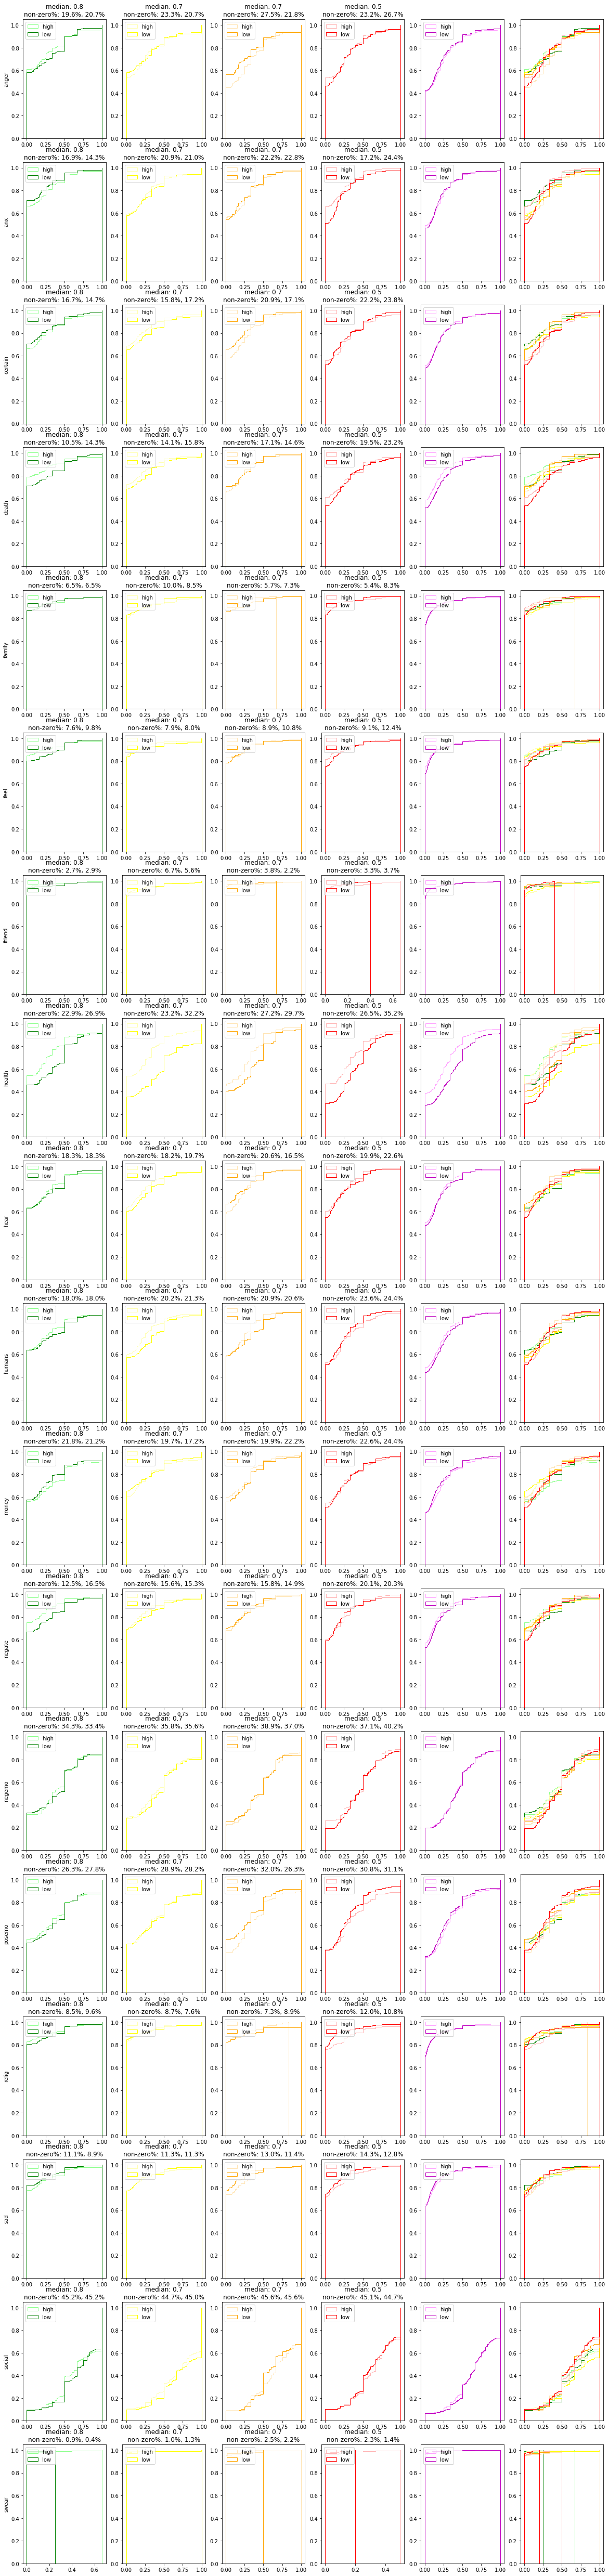

In [10]:
#LIWC by color - velocity

plot_df = all_nodes_df

velocity = 'velocity_ratio'
# velocity = 'lifespan'
# velocity = 'halflife'


scale = lambda x:x

cumulative = True

fig, ax = plt.subplots(len(candidates), 6, figsize=(20, 90))

# fig.suptitle("CDF of LIWC features Grouped by High/Low Popularities (blue represents all nodes)", fontsize="x-large")

for j, feat in enumerate(candidates):
    for i, color in enumerate(non_mix_COLORS):
        _color_data = plot_df[(plot_df['color'] == COLORS.index(color))]

        _pop = _color_data[velocity]
        
        _high_data = _color_data[_color_data[velocity] >= np.median(_pop)][feat]
        _low_data = _color_data[_color_data[velocity] < np.median(_pop)][feat]

        ax[j][i].hist(_high_data, color=lighten_color(color, 0.3), density=True, bins=400, cumulative=cumulative, histtype='step', label='high')
        ax[j][i].hist(_low_data, color=lighten_color(color, 1.0), density=True, bins=400, cumulative=cumulative, histtype='step', label='low')

        ax[j][i].legend(loc='upper left')

        
        _high_length = len([item for item in _high_data if (item > 0 and item <= 1)])
        _low_length = len([item for item in _low_data if (item > 0 and item <= 1)])
        
        ax[j][i].set_title(f'median: {np.median(_pop):.1f}\nnon-zero%: {_high_length/len(_color_data)*100:.1f}%, {_low_length/len(_color_data)*100:.1f}%')

        
        ax[j][5].hist(_high_data, color=lighten_color(color, 0.3), density=True, bins=400, cumulative=cumulative, histtype='step', label='high')
        ax[j][5].hist(_low_data, color=lighten_color(color, 1.0), density=True, bins=400, cumulative=cumulative, histtype='step', label='low')


    _pop = plot_df[velocity]
    _high_data = plot_df[plot_df[velocity] >= np.median(_pop)]
    _low_data = plot_df[plot_df[velocity] < np.median(_pop)]


    ax[j][4].hist(_high_data[feat], color=lighten_color('m', 0.3), density=True, bins=400, cumulative=True, histtype='step', label='high')
    ax[j][4].hist(_low_data[feat], color=lighten_color('m', 1.0), density=True, bins=400, cumulative=True, histtype='step', label='low')

    ax[j][4].legend(loc='upper left')
    ax[j][0].set_ylabel(feat)


plt.show()


In most cases the cdf of LIWC features over high/low veocity are not significant, espicially on red nodes/all nodes. 

In **certain, death, and anger**, red nodes (including high/low velocity) generally having distributions to the right side compared to greens. In **anx, health, feel and social** there are the only observable differences over high/low velocity red nodes. In **anx, health, feel**, low-velocity red nodes are genenerally having larger heath scores, and in **social** the situation is reversed: low-velocity red nodes are having smaller social scores. This would conclude that in investigating the velocity of propagation of red nodes (articles), low-velocity nodes are generally used less with social oriented words and more with health, feeling and anxiety related words.


As to **lifespan** or **halflife**, the LIWCs provides still little information in distinguishing high/low data groups. I hide those plots due to space limit.


# Q2-2: what are the LIWC patterns for story subjects over weeks? 

In [ ]:
#LIWC -> weekly change


plot_df = weekly_nodes_df
selected_LIWC = ['anger', 'anx', 'certain', 'death', 'health', 'negate', 'posemo', 'negemo', 'social']


for feat in selected_LIWC:
    fig, ax = plt.subplots(1, 1, figsize=(20, 5))
    
    
    for color in non_mix_COLORS:
        
        weekly_data = []
        for week in WEEKS:
            _data = weekly_nodes_df[(weekly_nodes_df['color'] == COLORS.index(color)) & (weekly_nodes_df['week'] == week)][feat]
             
            weekly_data.append(np.mean(_data))
            
        ax.plot(weekly_data, color=color)
    
    ax.set_ylabel(f'{feat}')
    ax.get_xaxis().set_visible(True)
    ax.set_xticks(range(len(WEEKS)))
    ax.set_xticklabels([f'{item:.0f}' for item in WEEKS])
    ax.set_xlabel('week')
    
    plt.show()



# Q3-1: what are rumors (represent the span of a rumor in narrative graphs)?

## A case exploration for finalizing definitions: bioweapon-coronavirus at week 7

***Definition of a Rumor in Narrative Graph***: all actants/triplets appeared in the same article where the rumor actants appeared in.


***RQ3-1-1***: is the above definition making sense?

In [15]:
inspect_week = 7

G, GD, nodes_in_graph, und_edges_in_graph, dir_edges_in_graph = pickle.load(open(f'output/graph_title+1s_week_{inspect_week}.pkl', 'rb'))

BY_WEEK_RELS, BY_WEEK_RAW = pickle.load(open(f'data/{"title+1s"}_by_week.pkl', 'rb'))


rumor_actants = ['bioweapon']
suspicious_posts = set([])

s_posts_edges = {}
suspicious_nodes = set([])
suspicious_edges = set([])
for ra in rumor_actants:
    for nb in G.neighbors(ra):
        if nb < ra:
            _edge_name = f'{nb}<->{ra}'
        else:
            _edge_name = f'{ra}<->{nb}'

        _edge_meta = und_edges_in_graph[_edge_name]
        _posts = set([])
        for verb in _edge_meta:
            _posts = _posts | verb['posts']

        suspicious_posts.update(_posts)                                     

for edge in G.edges:
    if edge[0] < edge[1]:
        edge_name = f'{edge[0]}<->{edge[1]}'
    else:
        edge_name = f'{edge[1]}<->{edge[0]}'
    
    for item in und_edges_in_graph[edge_name]:
        for post in item['posts']:
            if post in suspicious_posts:
                if post not in s_posts_edges:
                    s_posts_edges[post] = set([])
                s_posts_edges[post].add(edge)
                suspicious_edges.add(edge)
        
for post in s_posts_edges:
    for edge in s_posts_edges[post]:
        suspicious_nodes.add(edge[0])
        suspicious_nodes.add(edge[1])

## posts that created the edges of rumor:

In [16]:
for post in s_posts_edges:
    art = BY_WEEK_RAW[inspect_week][post]
    print(f'Post title: {art["title"]}')
    print(f'Domain: {art["domain"]}')
    sent = art["text"].split(".\n")[0]
    print(f'First sent: {sent}')
    print()
    print('Edges:')
    for edge in s_posts_edges[post]:
        print(edge)
          
    print('----------------------------------------------------')
    print()

Post title: Coronavirus death toll tops 900 as Chinas envoy to US dismisses absolutely crazy bioweapon rumors
Domain: endtimeheadlines.org
First sent: )  As the death toll from the novel coronavirus outbreak soared to over 900 people worldwide, the Chinese ambassador to the US has cautioned against fueling panic and spreading dangerous rumors about the virus still unknown origins

Edges:
('SUPER:death|death_toll', 'SUPER:ambassador|diplomat')
('bioweapon', 'top')
----------------------------------------------------

Post title: Yes, coronavirus is a BIOWEAPON with gene sequencing thats only possible if it was genetically modified in a lab
Domain: dcclothesline.com
First sent: (Natural News) The truth about novel coronavirus is starting to trickle its way out of the realm of independent science with new research pointing to strange anomalies in the viruss genetic structure that suggest its more than likely a bioweapon

Edges:
('SUPER:oak_medical_centre|lab|laboratory', 'bioweapon')
----

We can find that 3 of the areticles are copying the same sentence though with different titles. 

The materials are not only creating connected rumor components in the graph, but also disjoint relationships, for instance, "mainstream press", "brand", "notion".

The sub-graph of such component is as below:

/home/muheng/.local/lib/python3.7/site-packages/networkx/drawing/layout.py:950: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.row_stack((pos[x] for x in node_list))


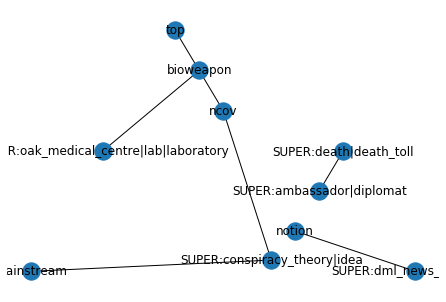

In [19]:
rumor = nx.Graph(G.subgraph(suspicious_nodes))
pos = nx.planar_layout(rumor)
for edge in rumor.edges():
    if (edge[0], edge[1]) not in suspicious_edges and (edge[1], edge[0]) not in suspicious_edges:
          rumor.remove_edge(edge[0], edge[1])

pos['SUPER:conspiracy_theory|idea'] -= np.array([0, 0.2])
nx.draw(rumor, pos=pos, with_labels = True)

It seems if keeping the major component in such sub-graphs, we can find the reasonble cluster representing the rumor's span over the full graph. To exam, I plot the same rumor on week 5 to validate:


Post title: Coronavirus Contains HIV Insertions, Stoking Fears Over Artificially Created Bioweapon
Domain: infowars.com
First sent: Over the past few days, the mainstream press has vigorously pushed back against a theory about the origins of the coronavirus that has now infected as many as 70,000+ people in Wuhan alone (depending on whom you believe). The theory is that China obtained the coronavirus via a Canadian research program, and started molding it into a bioweapon at the Institute of Virology in Wuhan. Politifact pointed the finger at Zero Hedge, in particular, though the story was widely shared across independent-leaning media

Edges:
('SUPER:amid_fear|fear', 'bioweapon')
('SUPER:press|comment|confusion', 'SUPER:day|night')
('SUPER:press|comment|confusion', 'SUPER:theory|theorist')
('coronavirus', 'SUPER:<<NUM>>_people|<<NUM>>_case|<<NUM>>_death')
('SUPER:passage|insertion', 'SUPER:amid_fear|fear')
('SUPER:you|me', 'SUPER:which|whom')
('coronavirus', 'SUPER:passage|insertion')

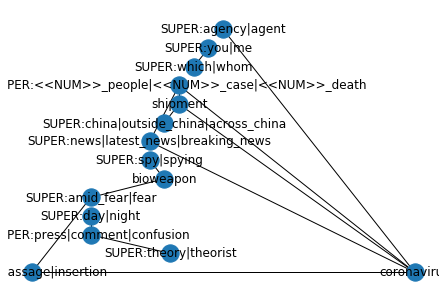

In [21]:
inspect_week = 5

G, GD, nodes_in_graph, und_edges_in_graph, dir_edges_in_graph = pickle.load(open(f'output/graph_title+1s_week_{inspect_week}.pkl', 'rb'))

# BY_WEEK_RELS, BY_WEEK_RAW = pickle.load(open(f'data/{"title+1s"}_by_week.pkl', 'rb'))


rumor_actants = ['bioweapon']
suspicious_posts = set([])

s_posts_edges = {}
suspicious_edges = set([])
suspicious_nodes = set([])

for ra in rumor_actants:
    for nb in G.neighbors(ra):
        if nb < ra:
            _edge_name = f'{nb}<->{ra}'
        else:
            _edge_name = f'{ra}<->{nb}'

        _edge_meta = und_edges_in_graph[_edge_name]
        _posts = set([])
        for verb in _edge_meta:
            _posts = _posts | verb['posts']

        suspicious_posts.update(_posts)                                     

for edge in G.edges:
    if edge[0] < edge[1]:
        edge_name = f'{edge[0]}<->{edge[1]}'
    else:
        edge_name = f'{edge[1]}<->{edge[0]}'
    
    for item in und_edges_in_graph[edge_name]:
        for post in item['posts']:
            if post in suspicious_posts:
                if post not in s_posts_edges:
                    s_posts_edges[post] = set([])
                s_posts_edges[post].add(edge)
                suspicious_edges.add(edge)
        
for post in s_posts_edges:
    for edge in s_posts_edges[post]:
        suspicious_nodes.add(edge[0])
        suspicious_nodes.add(edge[1])

for post in s_posts_edges:
    art = BY_WEEK_RAW[inspect_week][post]
    print(f'Post title: {art["title"]}')
    print(f'Domain: {art["domain"]}')
    sent = art["text"].split(".\n")[0]
    print(f'First sent: {sent}')
    print()
    print('Edges:')
    for edge in s_posts_edges[post]:
        print(edge)
          
    print('----------------------------------------------------')
    print()
          
          
rumor = nx.Graph(G.subgraph(suspicious_nodes))
pos = nx.planar_layout(rumor)
for edge in rumor.edges():
    if (edge[0], edge[1]) not in suspicious_edges and (edge[1], edge[0]) not in suspicious_edges:
          rumor.remove_edge(edge[0], edge[1])
pos['SUPER:theory|theorist'] += np.array([0.2, 0])
nx.draw(rumor, pos=pos, with_labels = True)

Unlike the previous example, this time most of the nodes connect to each other. Yet with the largest component here, we still have a reasonable cluster of "bioweapon" rumor. Only a few words (i.e. breaking_news) is wrongly included.